In [136]:
import pandas as pd
import numpy as np
import networkx as nx
from timezonefinder import TimezoneFinder
from pytz import timezone, utc
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Cleanup

In [3]:
df = pd.read_csv('data/DataSample.csv')

In [4]:
df.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22025 entries, 0 to 22024
Data columns (total 7 columns):
_ID          22025 non-null int64
 TimeSt      22025 non-null object
Country      22025 non-null object
Province     22025 non-null object
City         22025 non-null object
Latitude     22025 non-null float64
Longitude    22025 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ MB


In [6]:
# Drop duplicates, ignoring ID
df.drop_duplicates(subset=[' TimeSt', 'Latitude','Longitude'],inplace=True)
df.reset_index(drop=True,inplace=True)

### 2. Label

In [7]:
df_pois = pd.read_csv('data/POIList.csv')

In [9]:
df_pois

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [16]:
# Looks like POI1 and POI2 are the same - so remove POI2
df_pois.drop_duplicates(subset=[' Latitude','Longitude'],inplace=True)
df_pois.reset_index(drop=True,inplace=True)

In [22]:
df_pois

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI3,45.521629,-73.566024
2,POI4,45.224830,-63.232729


In [17]:
# Optimized this function to use numpy arrays
def distance(lat1, lon1, lat2, lon2):
    p = np.pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    return 12742 * np.arcsin(np.sqrt(a))

In [18]:
# Set lat and long values
lat1 = df['Latitude'].values
lat2 = df_pois[' Latitude'].values.reshape(-1,1)
lon1 = df['Longitude'].values
lon2 = df_pois['Longitude'].values.reshape(-1,1)

In [19]:
distances = distance(lat1, lon1, lat2, lon2)

In [20]:
df['Closest POI'] = pd.Series(np.argmin(distances,axis=0)).replace(df_pois['POIID'])
df['POI Distance'] = np.min(distances,axis=0)

In [23]:
df.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Closest POI,POI Distance
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3,593.413441
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3,677.309655
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3,569.647737
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3,634.733996
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3,634.733996


### 3. Analysis

In [26]:
# Analytics
df_pois['Average Distance'] = df.groupby('Closest POI')['POI Distance'].mean().values
df_pois['Std Distance'] = df.groupby('Closest POI')['POI Distance'].std().values
df_pois['Radius'] = df.groupby('Closest POI')['POI Distance'].max().values
df_pois['Area'] = np.pi * np.power(df_pois['Radius'],2)
df_pois['Requests'] = df['Closest POI'].value_counts().values
df_pois['Density'] = df_pois['Requests'] / df_pois['Area']

In [27]:
df_pois

,POIID,Latitude,Longitude,Average Distance,Std Distance,Radius,Area,Requests,Density
0,POI1,53.546167,-113.485734,301.906858,412.430033,11531.820832,4.177781e+08,9795,0.000023
1,POI3,45.521629,-73.566024,451.527555,223.350558,1474.580962,6.831045e+06,9727,0.001424
2,POI4,45.224830,-63.232729,497.278727,1472.937800,9349.572770,2.746208e+08,477,0.000002


### 4a. Model

#### Hypothesis: Latitude and longitude can be trusted and match location info
- To test this, get time zone information using timezonefinder package
- Some lats/longs do not match with supposed city
- e.g., city = Toronto and time zone = 'Europe/Berlin'
- Therefore filter out all time zones that don't have America in them
- Grouping by time zone and viewing unique cities shows that the other data look ok
- Filtering removes extreme values that are probably erroneous
- Conclusion: after filtering, lat and long can be trusted

In [28]:
# Change time stamps to datetime
df[' TimeSt'] = pd.to_datetime(df[' TimeSt'])

In [29]:
# Find time zones for each location
tf = TimezoneFinder(in_memory=True)

In [30]:
# Get time zone for each lat and long
df['TimeZone'] = df[['Latitude','Longitude']].apply(lambda row: 
                                                    tf.timezone_at(lat=row['Latitude'],lng=row['Longitude']),axis=1)

In [31]:
# Some odd time zones like Europe and Asia
df['TimeZone'].unique()

array(['America/Toronto', 'America/Regina', 'America/Edmonton',
       'America/Thunder_Bay', 'America/Vancouver', 'America/Moncton',
       'America/Halifax', 'America/Glace_Bay', 'America/Winnipeg',
       'America/St_Johns', 'America/Swift_Current', 'Asia/Tehran',
       'America/Dawson_Creek', 'America/Detroit', 'Asia/Manila',
       'America/Whitehorse', 'America/New_York', 'America/Yellowknife',
       'America/Rankin_Inlet', 'Asia/Riyadh', 'America/Nipigon',
       'America/Atikokan', 'Europe/Berlin'], dtype=object)

In [35]:
# Claims to be Toronto yet the lat/long is in Germany
df.loc[df['TimeZone'] == 'Europe/Berlin',:]

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Closest POI,POI Distance,TimeZone
12702,5215632,2017-06-21 05:49:04.917,CA,ON,Toronto,51.29930,9.49100,POI4,5201.819069,Europe/Berlin
15553,5373264,2017-06-21 02:00:23.357,CA,ON,Toronto,48.73082,9.24356,POI4,5300.321600,Europe/Berlin


In [36]:
# Filter out non-America timestamps
df.drop(df.loc[~df['TimeZone'].str.contains('America')].index,inplace=True)

In [37]:
# What about New York and Detroit? Not Canada...
df['TimeZone'].unique()

array(['America/Toronto', 'America/Regina', 'America/Edmonton',
       'America/Thunder_Bay', 'America/Vancouver', 'America/Moncton',
       'America/Halifax', 'America/Glace_Bay', 'America/Winnipeg',
       'America/St_Johns', 'America/Swift_Current',
       'America/Dawson_Creek', 'America/Detroit', 'America/Whitehorse',
       'America/New_York', 'America/Yellowknife', 'America/Rankin_Inlet',
       'America/Nipigon', 'America/Atikokan'], dtype=object)

In [38]:
# Windsor/Sarnia etc. are near Detroit
df.loc[df['TimeZone'] == 'America/Detroit',:]

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Closest POI,POI Distance,TimeZone
3383,4700802,2017-06-21 00:11:35.800,CA,ON,Petrolia,42.88486,-82.47845,POI3,768.009756,America/Detroit
5498,4818836,2017-06-21 05:20:36.200,CA,ON,Petrolia,42.88485,-82.47829,POI3,767.998468,America/Detroit
5499,4818900,2017-06-21 14:20:36.040,CA,ON,Petrolia,42.88485,-82.47829,POI3,767.998468,America/Detroit
7420,4925175,2017-06-21 15:29:49.843,CA,ON,Windsor,42.33644,-83.03145,POI3,835.965951,America/Detroit
9249,5026522,2017-06-21 18:35:41.117,CA,ON,Petrolia,42.88485,-82.47828,POI3,767.997733,America/Detroit
9272,5027602,2017-06-21 18:35:45.250,CA,ON,Windsor,42.33644,-83.03145,POI3,835.965951,America/Detroit
9296,5028893,2017-06-21 08:35:54.827,CA,ON,Petrolia,42.88485,-82.47828,POI3,767.997733,America/Detroit
9719,5052527,2017-06-21 08:37:34.263,CA,ON,Petrolia,42.88485,-82.47828,POI3,767.997733,America/Detroit
10279,5082912,2017-06-21 12:39:39.027,CA,ON,Petrolia,42.88485,-82.47828,POI3,767.997733,America/Detroit
10693,5105172,2017-06-21 08:41:26.567,CA,ON,Windsor,42.36169,-82.99888,POI3,832.279730,America/Detroit


In [41]:
# New York is in Niagara Falls - this is fine
df.loc[df['TimeZone'] == 'America/New_York',:]

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Closest POI,POI Distance,TimeZone
4242,4749184,2017-06-21 03:15:12.380,CA,ON,Niagara Falls,43.08371,-79.06058,POI3,514.282716,America/New_York
10675,5104086,2017-06-21 08:41:18.777,CA,ON,Niagara Falls,43.08398,-79.06054,POI3,514.263358,America/New_York


In [40]:
# Mostly they match up
df.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,Closest POI,POI Distance,TimeZone
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3,593.413441,America/Toronto
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3,677.309655,America/Toronto
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3,569.647737,America/Toronto
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3,634.733996,America/Toronto
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3,634.733996,America/Toronto


In [42]:
# The cities look reasonable
df.groupby('TimeZone')['City'].unique()

TimeZone
America/Atikokan                                                [Atikokan]
America/Dawson_Creek     [Fort Saint John, Dawson Creek, Fort St John, ...
America/Detroit                  [Petrolia, Windsor, Point Edward, Sarnia]
America/Edmonton         [Edmonton, Calgary, Lethbridge, Rocky Mountain...
America/Glace_Bay        [New Waterford, Sydney, North Sydney, Glace Ba...
America/Halifax          [Elmsdale, Halifax, Dartmouth, Weymouth, Kentv...
America/Moncton          [Moncton, Fredericton, Saint John, Oromocto, J...
America/New_York                                           [Niagara Falls]
America/Nipigon                                                  [Nipigon]
America/Rankin_Inlet                             [Pointe-Claire, Montreal]
America/Regina           [Saskatoon, Coronach, Prince Albert, Regina, M...
America/St_Johns         [St. John's, Grand Falls-Windsor, Mount Pearl,...
America/Swift_Current                                      [Swift Current]
America/Thunder_

In [32]:
# Point of interest timezones
df_pois['TimeZone'] = df_pois[[' Latitude','Longitude']].apply(lambda row: tf.timezone_at(lat=row[' Latitude'],lng=row['Longitude']),axis=1)

In [33]:
df_pois

,POIID,Latitude,Longitude,Average Distance,Std Distance,Radius,Area,Requests,Density,TimeZone
0,POI1,53.546167,-113.485734,301.906858,412.430033,11531.820832,4.177781e+08,9795,0.000023,America/Edmonton
1,POI3,45.521629,-73.566024,451.527555,223.350558,1474.580962,6.831045e+06,9727,0.001424,America/Toronto
2,POI4,45.224830,-63.232729,497.278727,1472.937800,9349.572770,2.746208e+08,477,0.000002,America/Halifax


#### Hypothesis: Times are in local time (as they are not time zone coded)
- Look at the histogram of number of requests sent each hour of the day
- Uniformly districted from morning to evening in raw form
- Transform to localised time based on time zone
- Now there are more requests in the late evening and early morning with gaps in the late afternoon
- Conclusion: likely that times are indeed in local time (odd shape of transformed distribution is not very informative, so not enough evidence to reject H0)

In [55]:
# Mark timestamps as UTC and transform them to potential localized time
df['timestamp_assuming_utc'] = df.apply(lambda x: utc.localize(x[' TimeSt']),axis=1)
df['timestamp_localized'] = df.apply(lambda x: timezone(x['TimeZone']).localize(x[' TimeSt']),axis=1)
df['local_time'] = df.apply(lambda x: x['timestamp_assuming_utc'].tz_convert(x['TimeZone']).tz_localize(None),axis=1)

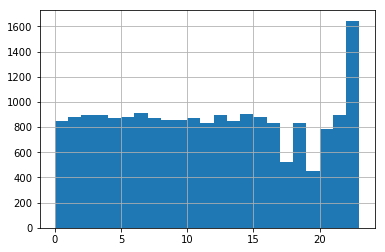

In [61]:
# Now we can test the times again - some weird peaks at the end of the day
df['hour_of_day_localized'] = df['local_time'].dt.hour
df['hour_of_day_localized'].hist(bins=23);

#### Hypothesis: All IDs in dataset (after deduplication for geodata) are unique
- The IDs are a form of anonymised identification of a device (i.e., they are all separate devices)
- So check to see if we have any duplicated device IDs. We probably don't want to count people twice.
- Number of records: 19977
- Number of unique IDs: 19977
- Conclusion: IDs in dataset are unique

In [62]:
# Number of records
df.shape[0]

19977

In [65]:
# Number of unique IDs
len(df['_ID'].unique())

19977

#### Hypothesis: More requests at certain times of day affect popularity
- All data are from a Wednesday, assume normal working day (not a holiday)
- People are more likely to visit the POI outside working hours (assumption)
- Should requests outside working hours/at lunchtimes be weighted higher?
- Current data set does not show signs of differential requests at different times of day
- Conclusion: No evidence that time of day has an impact on request density etc.

In [66]:
# Looking at timestamps - all the same date so we can ignore that as a factor
df[' TimeSt'].dt.date.unique()

array([datetime.date(2017, 6, 21)], dtype=object)

In [68]:
# Day of week is a Wednesday (Monday = 0, Tuesday = 1, Wednesday = 2)
df.loc[0,' TimeSt'].dayofweek

2

In [319]:
# Looking at timestamps - all the same date so we can ignore that as a factor
df[' TimeSt'].dt.date.unique()

array([datetime.date(2017, 6, 21)], dtype=object)

#### Model building

What would a good model look like? Popularity from most to least?
- Tourist attraction in a big city (e.g., CN Tower)
- Restaurant/mall/etc. in a big city
- Tourist attraction/mall etc. in or near a smaller city
- Middle of nowhere

What would be a reasonable answer?
- POI1 is in Edmonton, high population and Calgary nearby so probably quite popular (between 0 and 10)
- POI3 is in the middle of Montreal, so likely to be very popular (so a 10)
- POI4 is in the countryside in Nova Scotia, probably not popular at all (so a -10)
- This is hard to test as we have so few points

In [70]:
# Function to map raw scores to POI map from -10 to 10
def map_raw_scores(raw_scores):

    op_start = -10
    op_end = 10
    ip_start = np.min(raw_scores)
    ip_end = np.max(raw_scores)

    output = op_start + ((op_end - op_start) / (ip_end - ip_start)) \
             * (raw_scores - ip_start)

    return output.round()

Density (requests/area) is a good starting measure of popularity

In [77]:
pop = map_raw_scores(df_pois['Density'])
pop.index = df_pois['POIID']
pop

POIID
POI1   -10.0
POI3    10.0
POI4   -10.0
Name: Density, dtype: float64

Request distance also factors in
- Closer requests should be weighted higher
- Reciprocal of distance will discount outliers a lot more

In [85]:
# Using reciprocal distance alone
pop = map_raw_scores(df.groupby('Closest POI')['POI Distance'].apply(lambda x: np.sum(np.reciprocal(x))))
pop

Closest POI
POI1    10.0
POI3    -2.0
POI4   -10.0
Name: POI Distance, dtype: float64

Now POI1 is the most popular, but it should be POI3.

In [86]:
# Multiplying the two
pop = map_raw_scores(df.groupby('Closest POI')['POI Distance']
                     .apply(lambda x: np.sum(np.reciprocal(x))) * df_pois['Density'].values)
pop

Closest POI
POI1    -9.0
POI3    10.0
POI4   -10.0
Name: POI Distance, dtype: float64

Better, but POI1 should still be more popular - modify weight of request distance $d$ and multiply by density $\rho$. Final result:

$popularity = \bigg[\displaystyle\sum(1/d)\bigg]^4 \times \rho$

In [87]:
def score_pois(df, df_pois):

    total = np.power(df.groupby('Closest POI')['POI Distance']
                     .apply(lambda x: np.sum(np.reciprocal(x))),4) *\
                     df_pois['Density'].values
    return total

In [88]:
map_raw_scores(score_pois(df,df_pois))

Closest POI
POI1     5.0
POI3    10.0
POI4   -10.0
Name: POI Distance, dtype: float64

Looks good. Standard deviation of request distance might also be a factor but request density takes care of a lot of this, they are negatively correlated (-0.62)

Something else I explored was the distribtions of the distances. This is covered by the reciprocal distance mainly, but the histograms show that POI1 has a concentrated number of requests nearby (Edmonton and Calgary) and POI3 has a few nearby and a lot from about 500 km away (i.e., Toronto).

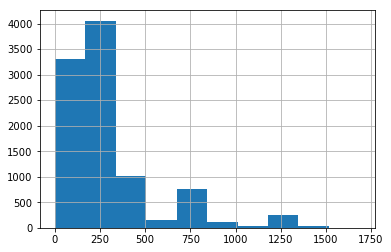

In [110]:
# Edmonton - includes Calgary around 300 km away
df.loc[df['Closest POI'] == 'POI1','POI Distance'].hist();

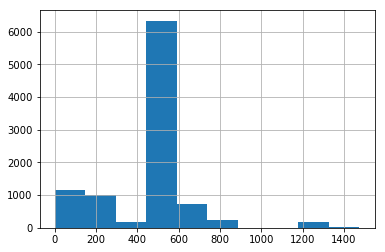

In [111]:
# Montreal - see peak for Toronto around 550 km away
df.loc[df['Closest POI'] == 'POI3','POI Distance'].hist();

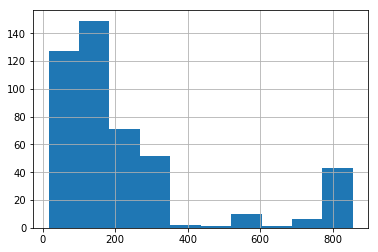

In [123]:
# Nova Scotia - far fewer requests, mostly from Halifax and NB, some as far as NL
df.loc[df['Closest POI'] == 'POI4','POI Distance'].hist();

In [124]:
# Get quartile radius for 25%, 50% and 75%
df_pois['Radius 25%'] = df.groupby('Closest POI')['POI Distance'].quantile(0.25).values
df_pois['Radius 50%'] = df.groupby('Closest POI')['POI Distance'].quantile(0.5).values
df_pois['Radius 75%'] = df.groupby('Closest POI')['POI Distance'].quantile(0.75).values
df_pois['Area 25%'] = np.pi * df_pois['Radius 25%']**2
df_pois['Area 50%'] = np.pi * df_pois['Radius 50%']**2
df_pois['Area 75%'] = np.pi * df_pois['Radius 75%']**2
df_pois['Density 25%'] = df_pois['Requests'] / (4*df_pois['Area 25%'])
df_pois['Density 50%'] = df_pois['Requests'] / (4*df_pois['Area 50%'])
df_pois['Density 75%'] = df_pois['Requests'] / (4*df_pois['Area 75%'])

In [128]:
# Note huge 25% density for POI1
df_pois

,POIID,Latitude,Longitude,Average Distance,Std Distance,Radius,Area,Requests,Density,TimeZone,Radius 25%,Radius 50%,Radius 75%,Area 25%,Area 50%,Area 75%,Density 25%,Density 50%,Density 75%
0,POI1,53.546167,-113.485734,301.906858,412.430033,11531.820832,4.177781e+08,9795,0.000023,America/Edmonton,15.237725,277.472314,303.940348,729.440937,241873.998856,290219.496951,3.357023,0.010124,0.008438
1,POI3,45.521629,-73.566024,451.527555,223.350558,1474.580962,6.831045e+06,9727,0.001424,America/Toronto,457.979232,504.990470,532.071770,658933.277656,801154.426991,889386.036759,0.003690,0.003035,0.002734
2,POI4,45.224830,-63.232729,497.278727,1472.937800,9349.572770,2.746208e+08,477,0.000002,America/Halifax,73.316823,157.030982,262.234040,16887.180820,77467.682627,216036.933838,0.007062,0.001539,0.000552


# 4b

In [129]:
# Read in tasks and dependencies
tasks = pd.read_csv('data/task_ids.txt',header=None).values[0]
dep_arr = pd.read_csv('data/relations.txt',header=None,sep='->',
                   engine='python').values
start_task = 73
goal_task = 36

In [130]:
# Get tasks from dependencies and current tasks running
def get_tasks(dep_arr,tasks,tasks_running):

    # Deal with scalars
    if isinstance(tasks,int):
        tasks = [tasks]

    for task in tasks:
        if task not in tasks_running:

            # If it has dependencies, call the function again
            deps = list(dep_arr[np.where(dep_arr[:,1] == task),0][0])
            if deps:
                tasks_running = get_tasks(dep_arr,deps,tasks_running)

            # Append the task to the list
            tasks_running.append(task)

    return tasks_running

In [131]:
# Get final task order
def get_task_order(start_task,end_task,dep_arr):

    tasks_running = []

    # Start initial tasks running (make sure we make a copy)
    initial_tasks = list(get_tasks(dep_arr,start_task,tasks_running))

    # Remove starting task for the initial run
    initial_tasks.pop(-1)

    # Final task list
    task_order = get_tasks(dep_arr,end_task,tasks_running)

    # Remove initial tasks from task order list
    [task_order.remove(task) for task in initial_tasks]

    return task_order

In [135]:
get_task_order(start_task,goal_task,dep_arr)

[73, 112, 100, 21, 20, 97, 94, 56, 102, 36]

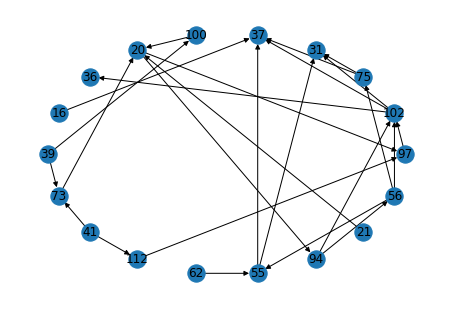

In [134]:
# Visualize dependency graph - requires networkx library
G = nx.DiGraph()
G.add_edges_from(dep_arr)
nx.draw_shell(G,with_labels=True)